In [51]:
#Import Libraries
import requests
import pandas as pd
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
# Load 2023/24 Match Data from API

api_token = '345041ac539f47d7b544c6a55b9f93f6'
headers = {'X-Auth-Token': api_token}
url = 'https://api.football-data.org/v4/competitions/2021/matches?season=2023'

response = requests.get(url, headers=headers)
data = response.json()

if 'matches' not in data:
    print("API issue:", data)
    matches = []
else:
    matches = data['matches']

In [53]:
# Build Historical Team Profiles
teams = {}

for match in matches:
    if match['status'] != 'FINISHED':
        continue
    home, away = match['homeTeam']['name'], match['awayTeam']['name']
    home_goals, away_goals = match['score']['fullTime']['home'], match['score']['fullTime']['away']

    for team in [home, away]:
        if team not in teams:
            teams[team] = {'Wins': 0, 'Goals For': 0, 'Goals Against': 0, 'Matches': 0}

    teams[home]['Matches'] += 1
    teams[away]['Matches'] += 1

    teams[home]['Goals For'] += home_goals
    teams[home]['Goals Against'] += away_goals
    teams[away]['Goals For'] += away_goals
    teams[away]['Goals Against'] += home_goals

    if home_goals > away_goals:
        teams[home]['Wins'] += 1
    elif away_goals > home_goals:
        teams[away]['Wins'] += 1


In [54]:
# Calculate Performance Metric

df = pd.DataFrame.from_dict(teams, orient='index').reset_index()
df.rename(columns={'index': 'Team'}, inplace=True)
df['Win Rate'] = (df['Wins'] / df['Matches']).round(3)
df['Goal Ratio'] = (df['Goals For'] / df['Goals Against']).replace([float('inf'), pd.NA], 0).round(2)
df.sort_values(by='Win Rate', ascending=False, inplace=True)

In [55]:
# View part of the data
df.head()

,Team,Wins,Goals For,Goals Against,Matches,Win Rate,Goal Ratio
1,Manchester City FC,28,96,34,38,0.737,2.82
2,Arsenal FC,28,91,29,38,0.737,3.14
17,Liverpool FC,24,86,41,38,0.632,2.10
13,Aston Villa FC,20,76,61,38,0.526,1.25
15,Tottenham Hotspur FC,20,74,61,38,0.526,1.21


In [56]:
        # Predict 2024/25 Wins
# Let’s estimate future performance by blending win rate and goal ratio as a team strength index:
df['Strength Index'] = ((df['Win Rate'] * 0.7) + (df['Goal Ratio'] * 0.3)).round(3)
df['Predicted Wins 2024/25'] = (df['Strength Index'] * 38).round()


C:\Users\mwang\AppData\Local\Temp\ipykernel_15896\1229470069.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_df, x='Predicted Wins 2024/25', y='Team', palette='icefire')


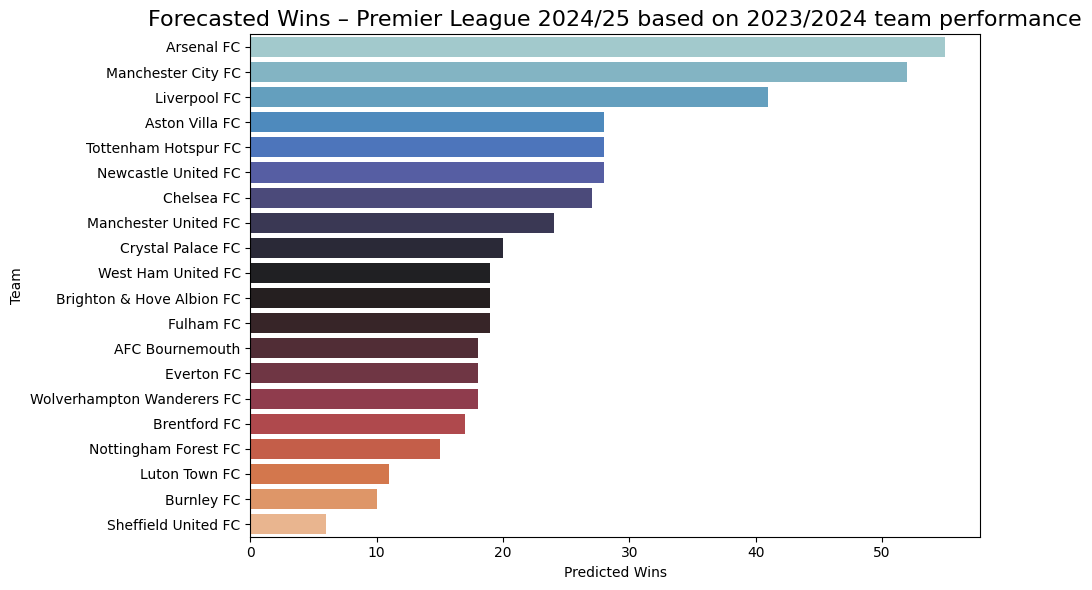

In [ ]:
# Sort the DataFrame by predicted wins
sorted_df = df.sort_values(by='Predicted Wins 2024/25', ascending=False)

# Visualize the data
plt.figure(figsize=(10, 6))
sns.barplot(data=sorted_df, x='Predicted Wins 2024/25', y='Team', palette='icefire')
plt.title('Forecasted Wins – Premier League 2024/25 based on 2023/2024 team performance', fontsize=16)
plt.xlabel('Predicted Wins')
plt.ylabel('Team')
plt.tight_layout()
plt.show()